In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

/home/plau/anaconda3/envs/timeGAN/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LSTMGenerator(nn.Module):
    """Generator with LSTM"""
    def __init__(self, latent_dim, ts_dim, hidden_dim=256, num_layers=1):
        super(LSTMGenerator, self).__init__()

        self.ts_dim = ts_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(num_layers*hidden_dim, num_layers*ts_dim)

    def forward(self, x):
        x = x.reshape(x.shape[0], self.num_layers, x.shape[1])
        out, _ = self.lstm(x)
        out = self.linear(out.reshape(x.size(0), x.size(1)*self.hidden_dim))
        out = out.view(x.size(0), self.ts_dim, self.num_layers)
        return out

In [3]:
noise_len = 144
n_samples = 24

In [4]:
generator_LSTM_without_CD_0 = {}


for n_groups in range(1,7):
    generator_LSTM_without_CD_0[n_groups] = {}


    for i in range(n_groups):
        generator_LSTM_without_CD_0[n_groups][i] = LSTMGenerator(noise_len, n_samples)


In [5]:
for n_groups in range(1,7):
    for i in range(n_groups):
        # LSTM
        # Without CD 0
        generator_LSTM_without_CD_0_temp_dict = torch.load(f'../../Results/Models/with_CD/Generator_{i}.pt', map_location=torch.device('cpu'))
        new_generator_LSTM_without_CD_0_temp_dict = deepcopy(generator_LSTM_without_CD_0_temp_dict)
        for key in generator_LSTM_without_CD_0_temp_dict.keys():
            new_generator_LSTM_without_CD_0_temp_dict[key[7:]] = new_generator_LSTM_without_CD_0_temp_dict.pop(key)
        generator_LSTM_without_CD_0[n_groups][i].load_state_dict(new_generator_LSTM_without_CD_0_temp_dict)

        

In [6]:
stock_data = pd.read_csv('../../Dataset/1035730_summary_10min_minMax_144.csv')
print(stock_data.shape)
stock_tensor = torch.tensor(stock_data.values, dtype=torch.float32) # Shape (1988, 144, 1)
print(stock_tensor.shape)
original_data_values = stock_data.to_numpy().reshape(stock_data.shape[0], -1, 6)

print(original_data_values.shape)

(1988, 144)
torch.Size([1988, 144])
(1988, 24, 6)


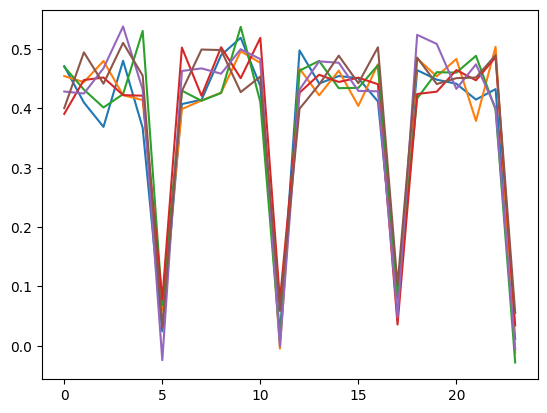

In [7]:
new_noise = torch.randn((1988, 144)).float()

generated_samples_LSTM_without_CD_0 = {}


for n_groups in range(1, 7):
    generated_samples_LSTM_without_CD_0[n_groups] = {}


    for i in range(n_groups):
        generated_samples_LSTM_without_CD_0[n_groups][i] = generator_LSTM_without_CD_0[n_groups][i](stock_tensor).detach().cpu().numpy()


plt.figure()
plt.plot(generated_samples_LSTM_without_CD_0[6][0][0, :], label='Signal 0')
plt.plot(generated_samples_LSTM_without_CD_0[6][1][0, :], label='Signal 1')
plt.plot(generated_samples_LSTM_without_CD_0[6][2][0, :], label='Signal 2')
plt.plot(generated_samples_LSTM_without_CD_0[6][3][0, :], label='Signal 3')
plt.plot(generated_samples_LSTM_without_CD_0[6][4][0, :], label='Signal 4')
plt.plot(generated_samples_LSTM_without_CD_0[6][5][0, :], label='Signal 4')
plt.show()


In [8]:
# create dataframe of generated samples
generated_samples_LSTM_without_CD_0_df = {}
generated_samples_LSTM_without_CD_1_df = {}
generated_samples_LSTM_MLP_with_CD_0_df = {}
generated_samples_LSTM_MLP_with_CD_1_df = {}
generated_samples_baseline_0_df = {}
generated_samples_baseline_1_df = {}

for n_groups in range(1, 7):
    generated_samples_LSTM_without_CD_0_df[n_groups] = {}
    generated_samples_LSTM_without_CD_1_df[n_groups] = {}
    generated_samples_LSTM_MLP_with_CD_0_df[n_groups] = {}
    generated_samples_LSTM_MLP_with_CD_1_df[n_groups] = {}
    generated_samples_baseline_0_df[n_groups] = {}
    generated_samples_baseline_1_df[n_groups] = {}

    for i in range(n_groups):
        generated_samples_LSTM_without_CD_0_df[n_groups][i] = pd.DataFrame(generated_samples_LSTM_without_CD_0[n_groups][i].squeeze())


In [9]:
# save generated samples to csv

for n_groups in range(1, 7):
    pd.concat([generated for generated in generated_samples_LSTM_without_CD_0_df[n_groups].values()], axis=1, ignore_index=True).to_csv(f'../../Results/generated_samples_LSTM_without_CD_0_{n_groups}.csv', index=False)
    